In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline


# Data

- https://www.moodys.com/sites/products/DefaultResearch/2006400000429618.pdf
- https://www.tradingview.com/symbols/NYSE-KO/bonds/

# Docs

Chapter 24: https://drive.google.com/file/d/1G2gLKsQgEWjt7YyLXXawjG9X2eQz1Pj3/view?usp=drive_link

# 1. Objective

Estimate the joint probability that n firms default by time t:

$$

\mathbb{P}(\tau_1 \leq t, \tau_2 \leq t, \ldots, \tau_n \leq t),

$$

where $\tau_i$ is the default time of firm i.

# 2: Estimating Default Probabilities

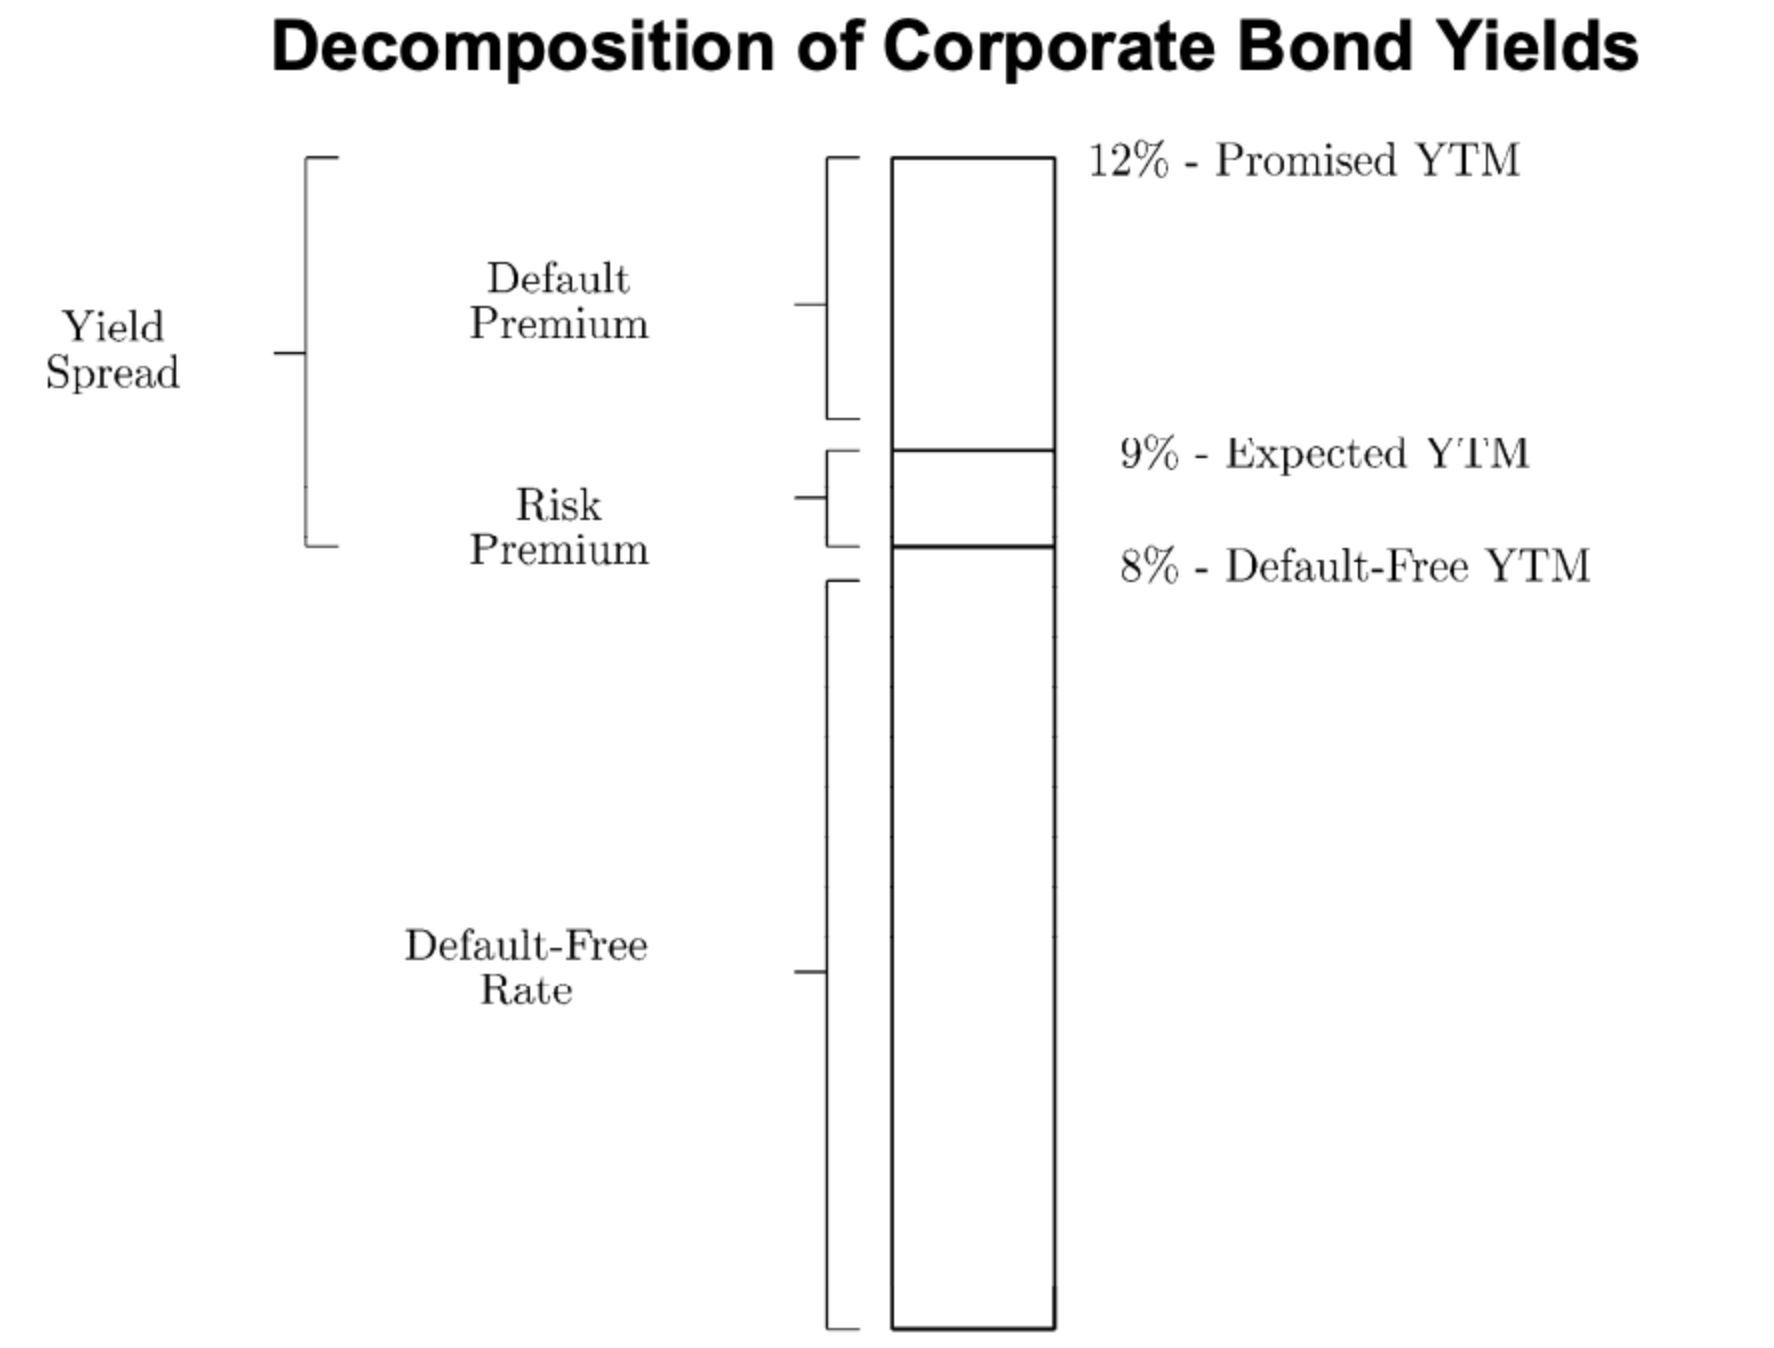

---
## 2.1. Using Moody data

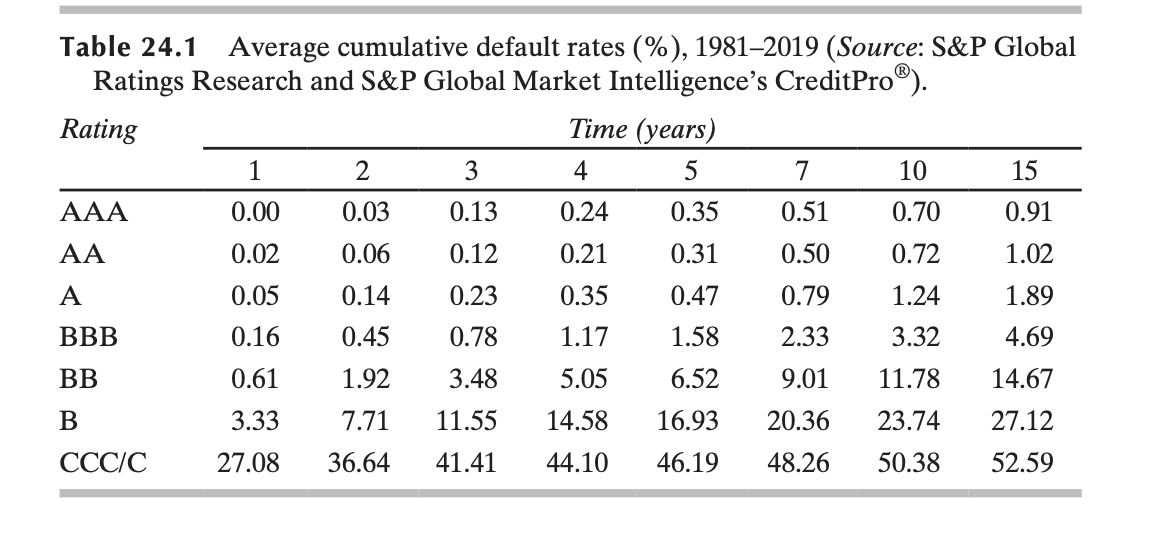

**A) From Cumulative Default Rate to Survival**

1. Obtain the cumulative default rate up to time $ t $: $ Q(t) $ (e.g., from S&P tables).

2. Calculate the survival probability (no default up to $ t $):  
   $$
   V(t) = 1 - Q(t).
   $$

**B) Default Probabilities in Each Interval $[t_{i-1}, t_i]$**

3. **Unconditional** default probability in year $ i $:  
   $$
   u_i = Q(t_i) - Q(t_{i-1}) = V(t_{i-1}) - V(t_i).
   $$

4. **Conditional** default probability, assuming survival to $ t_{i-1} $:  
   $$
   p_i = \frac{u_i}{V(t_{i-1})} = 1 - \frac{V(t_i)}{V(t_{i-1})}.
   $$

**C) From Conditional Probability to Hazard (Piecewise-Constant)**

5. Assuming a constant hazard rate in the interval $[t_{i-1}, t_i]$ with length $ \Delta t $:  
   $$
   p_i = 1 - e^{-\lambda_i \Delta t}
   \quad \Longleftrightarrow \quad
   \boxed{\lambda_i = -\frac{1}{\Delta t} \ln(1 - p_i)}
   = -\frac{1}{\Delta t} \ln\left(\frac{V(t_i)}{V(t_{i-1})}\right).
   $$  
   (For $ \Delta t = 1 $ year, $ \lambda_i \approx -\ln(1 - p_i) $.)

**D) Faster Way: Average Hazard up to Time $ t $**

6. Average hazard rate from 0 to $ t $:  
   $$
   \bar{\lambda}(t) = -\frac{1}{t} \ln V(t)
   \quad \Rightarrow \quad
   Q(t) = 1 - e^{-\bar{\lambda}(t) \cdot t}.
   $$


**(Optional) Quick Example for CCC/C Rating (from table):**

* $ Q(2) = 36.64\% \Rightarrow V(2) = 63.36\% $; $ Q(3) = 41.41\% \Rightarrow V(3) = 58.59\% $.
* Unconditional year 3: $ u_3 = 4.77\% $.
* Conditional year 3: $ p_3 = u_3 / V(2) = 7.53\% $.
* Hazard year 3 (piecewise constant): $ \lambda_3 = -\ln(1 - 0.0753) \approx 7.8\% $ per year  
  (equivalent to $ -\ln[V(3)/V(2)] $).

**Summary**: Read $ Q(t) $, compute $ V(t) $, derive $ p_i $, and convert to $ \lambda_i $ using $ -\ln(1 - p_i)/\Delta t $; or use $ \bar{\lambda}(t) = -\ln V(t)/t $ for the average hazard rate.

In [2]:

def build_credit_curve_historical(cum_defaults, mode="traditional"):
    survival_func = 1 - cum_defaults
    if mode == "traditional":
        hazard_rates = - np.log(survival_func[1:]/survival_func[:-1])
    else:
        hazard_rates = -1/len(cum_defaults)*np.log(survival_func[-1])
    return hazard_rates


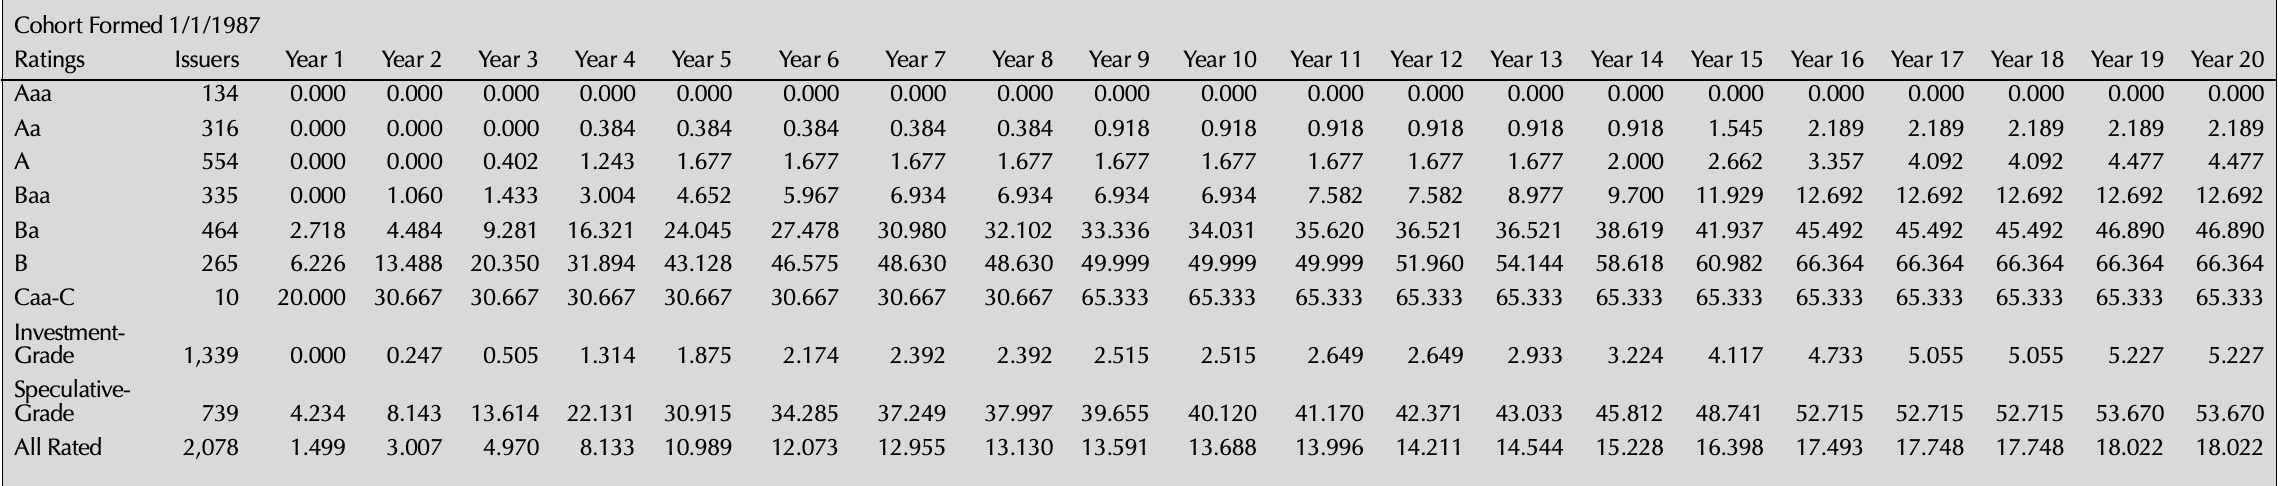

In [3]:
import pandas as pd

data = {
    # "Ratings": ["Aaa","Aa","A","Baa","Ba","B","Caa-C","Investment-Grade","Speculative-Grade","All Rated"],
    # "Issuers":[134,316,554,335,464,265,10,1339,739,2078],
    "Year1":[0.000,0.000,0.000,0.000,2.718,6.226,20.000,0.000,4.234,1.499],
    "Year2":[0.000,0.000,0.000,1.060,4.484,13.488,30.667,0.247,8.143,3.007],
    "Year3":[0.000,0.000,0.402,1.433,9.281,20.350,30.667,0.505,13.614,4.970],
    "Year4":[0.000,0.384,1.243,3.004,16.321,31.894,30.667,1.314,22.131,8.133],
    "Year5":[0.000,0.384,1.677,4.652,24.045,43.128,30.667,1.875,30.915,10.989],
    "Year6":[0.000,0.384,1.677,5.967,27.478,46.575,30.667,2.174,34.285,12.073],
    "Year7":[0.000,0.384,1.677,6.934,30.980,48.630,30.667,2.392,37.249,12.955],
    "Year8":[0.000,0.384,1.677,6.934,32.102,48.630,30.667,2.392,37.997,13.130],
    "Year9":[0.000,0.918,1.677,6.934,33.336,49.999,65.333,2.515,39.655,13.598],
    "Year10":[0.000,0.918,1.677,6.934,34.031,49.999,65.333,2.515,40.120,13.688],
    "Year11":[0.000,0.918,1.677,7.582,35.620,49.999,65.333,2.649,41.170,13.996],
    "Year12":[0.000,0.918,1.677,7.582,36.521,51.960,65.333,2.649,42.371,14.211],
    "Year13":[0.000,0.918,1.677,8.977,36.521,54.144,65.333,2.933,43.033,14.544],
    "Year14":[0.000,0.918,2.000,9.700,38.619,58.618,65.333,3.224,45.812,15.228],
    "Year15":[0.000,1.545,2.662,11.929,41.937,60.982,65.333,4.117,48.741,16.398],
    "Year16":[0.000,2.189,3.357,12.692,45.492,66.364,65.333,4.733,52.715,17.493],
    "Year17":[0.000,2.189,4.092,12.692,45.492,66.364,65.333,5.055,52.715,17.748],
    "Year18":[0.000,2.189,4.092,12.692,45.492,66.364,65.333,5.055,52.715,17.748],
    "Year19":[0.000,2.189,4.477,12.692,46.890,66.364,65.333,5.227,53.670,18.022],
    "Year20":[0.000,2.189,4.477,12.692,46.890,66.364,65.333,5.227,53.670,18.022],
}

df = pd.DataFrame(data,index = ["Aaa","Aa","A","Baa","Ba","B","Caa-C","Investment-Grade","Speculative-Grade","All Rated"])
cum_defaults = df/100
cum_defaults


,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Year12,Year13,Year14,Year15,Year16,Year17,Year18,Year19,Year20
Aaa,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Aa,0.00000,0.00000,0.00000,0.00384,0.00384,0.00384,0.00384,0.00384,0.00918,0.00918,0.00918,0.00918,0.00918,0.00918,0.01545,0.02189,0.02189,0.02189,0.02189,0.02189
A,0.00000,0.00000,0.00402,0.01243,0.01677,0.01677,0.01677,0.01677,0.01677,0.01677,0.01677,0.01677,0.01677,0.02000,0.02662,0.03357,0.04092,0.04092,0.04477,0.04477
Baa,0.00000,0.01060,0.01433,0.03004,0.04652,0.05967,0.06934,0.06934,0.06934,0.06934,0.07582,0.07582,0.08977,0.09700,0.11929,0.12692,0.12692,0.12692,0.12692,0.12692
Ba,0.02718,0.04484,0.09281,0.16321,0.24045,0.27478,0.30980,0.32102,0.33336,0.34031,0.35620,0.36521,0.36521,0.38619,0.41937,0.45492,0.45492,0.45492,0.46890,0.46890
B,0.06226,0.13488,0.20350,0.31894,0.43128,0.46575,0.48630,0.48630,0.49999,0.49999,0.49999,0.51960,0.54144,0.58618,0.60982,0.66364,0.66364,0.66364,0.66364,0.66364
Caa-C,0.20000,0.30667,0.30667,0.30667,0.30667,0.30667,0.30667,0.30667,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333,0.65333
Investment-Grade,0.00000,0.00247,0.00505,0.01314,0.01875,0.02174,0.02392,0.02392,0.02515,0.02515,0.02649,0.02649,0.02933,0.03224,0.04117,0.04733,0.05055,0.05055,0.05227,0.05227
Speculative-Grade,0.04234,0.08143,0.13614,0.22131,0.30915,0.34285,0.37249,0.37997,0.39655,0.40120,0.41170,0.42371,0.43033,0.45812,0.48741,0.52715,0.52715,0.52715,0.53670,0.53670
All Rated,0.01499,0.03007,0.04970,0.08133,0.10989,0.12073,0.12955,0.13130,0.13598,0.13688,0.13996,0.14211,0.14544,0.15228,0.16398,0.17493,0.17748,0.17748,0.18022,0.18022


In [4]:
class CreditCurve():
    def __init__(self,cum_defaults:pd.DataFrame,spread_curve:pd.Series=None, recovery_rate=0.5):
        self.cum_defaults = cum_defaults
        self.cum_survival = 1 - cum_defaults
        
        self.spread_curve = spread_curve
        self.recovery_rate = recovery_rate
    
    def calculate_hasard_rates(self, mode = "traditional") -> pd.DataFrame:
        if mode == "traditional":
            res = -np.log(self.cum_survival/self.cum_survival.shift(1,axis=1))
        elif mode == "spread":
            average_hazard = self.spread_curve / (1 - self.recovery_rate)
            time = np.arange(1,len(average_hazard)+1)    
            tmp = average_hazard*time
            result = tmp.diff()
            result.iloc[0] = tmp.iloc[0]
            result = pd.DataFrame(result)
            result.columns = ["Spread"]
            return result.T
        else:
            res = -np.log(self.cum_survival.iloc[:,-1])/self.cum_survival.shape[1]
            res = pd.DataFrame(res,columns=self.cum_defaults.columns,index=cum_defaults.index).bfill(axis=1)
        return res
            
    def calculate_cum_survival(self, mode = "traditional"):
        hasard_rate = self.calculate_hasard_rates(mode)
        res = np.exp(-hasard_rate.cumsum(axis=1))
        return res


    ######## Interpolation Survival Function

    def survival_piecewise_constant(self, hazard, times, t_query):
        hazard = np.asarray(hazard)
        times = np.asarray(times)

        # find which interval t belongs to
        idx = np.searchsorted(times, t_query) - 1
        idx = np.clip(idx, 0, len(hazard)-1)

        # cumulative hazard up to the beginning of interval
        cum_haz = np.sum(hazard[:idx] * np.diff(np.concatenate([[0], times]))[:idx])

        # add hazard * fractional time inside interval
        dt = t_query - times[idx]
        cum_haz += hazard[idx] * dt

        return np.exp(-cum_haz)


    def survival_piecewise_linear(self, hazard, times, t_query):
        f = interp1d(times, hazard, kind='linear', fill_value="extrapolate")
        
        # integrate hazard from 0 to t_query using many small steps
        ts = np.linspace(0, t_query, 500)
        hs = f(ts)
        cum_haz = np.trapz(hs, ts)
        
        return np.exp(-cum_haz)

    def survival_spline(self, hazard, times, t_query):
        spline = CubicSpline(times, hazard, bc_type="natural")
        
        ts = np.linspace(0, t_query, 500)
        hs = spline(ts)
        cum_haz = np.trapz(hs, ts)
        
        return np.exp(-cum_haz)
# def survival_func(self,t, h):
#     """Survival probability S(t) = exp(-h * t)"""
#     return np.exp(-h * t)

# def cdf_func(self,t, h):
#     """Cumulative default prob F(t) = 1 - S(t)"""
#     return 1 - self.survival_func(t, h)

In [5]:
credit_analysis = CreditCurve(cum_defaults)

### 2.1.1. Traditional way

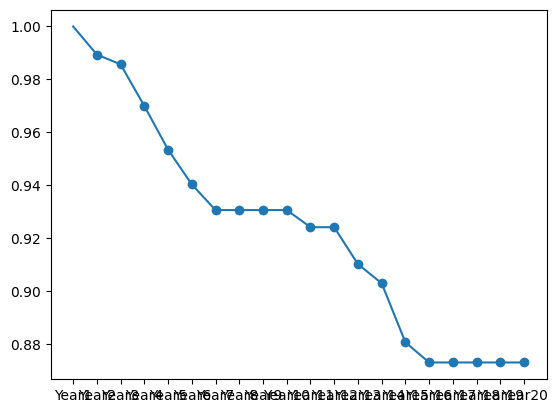

In [6]:
res=credit_analysis.calculate_cum_survival()
tic = "Baa"
plt.scatter(res.columns,res.loc[tic])
plt.plot(credit_analysis.cum_survival.loc[tic])

### 2.1.2. average hasard rate way

/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1107944693.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res = pd.DataFrame(res,columns=self.cum_defaults.columns,index=cum_defaults.index).bfill(axis=1)


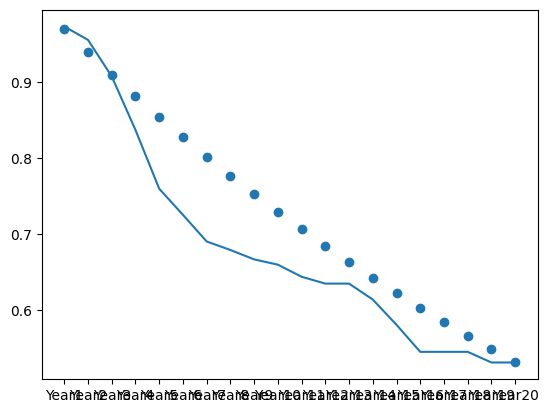

In [7]:
res=credit_analysis.calculate_cum_survival("average")
tic = "Ba"
plt.scatter(res.columns,res.loc[tic])
plt.plot(credit_analysis.cum_survival.loc[tic])

> **Note:** We can try to use some method to interpolate this curve like spline smoothing, regression,...


---
## 2.2. Using Spread Curve

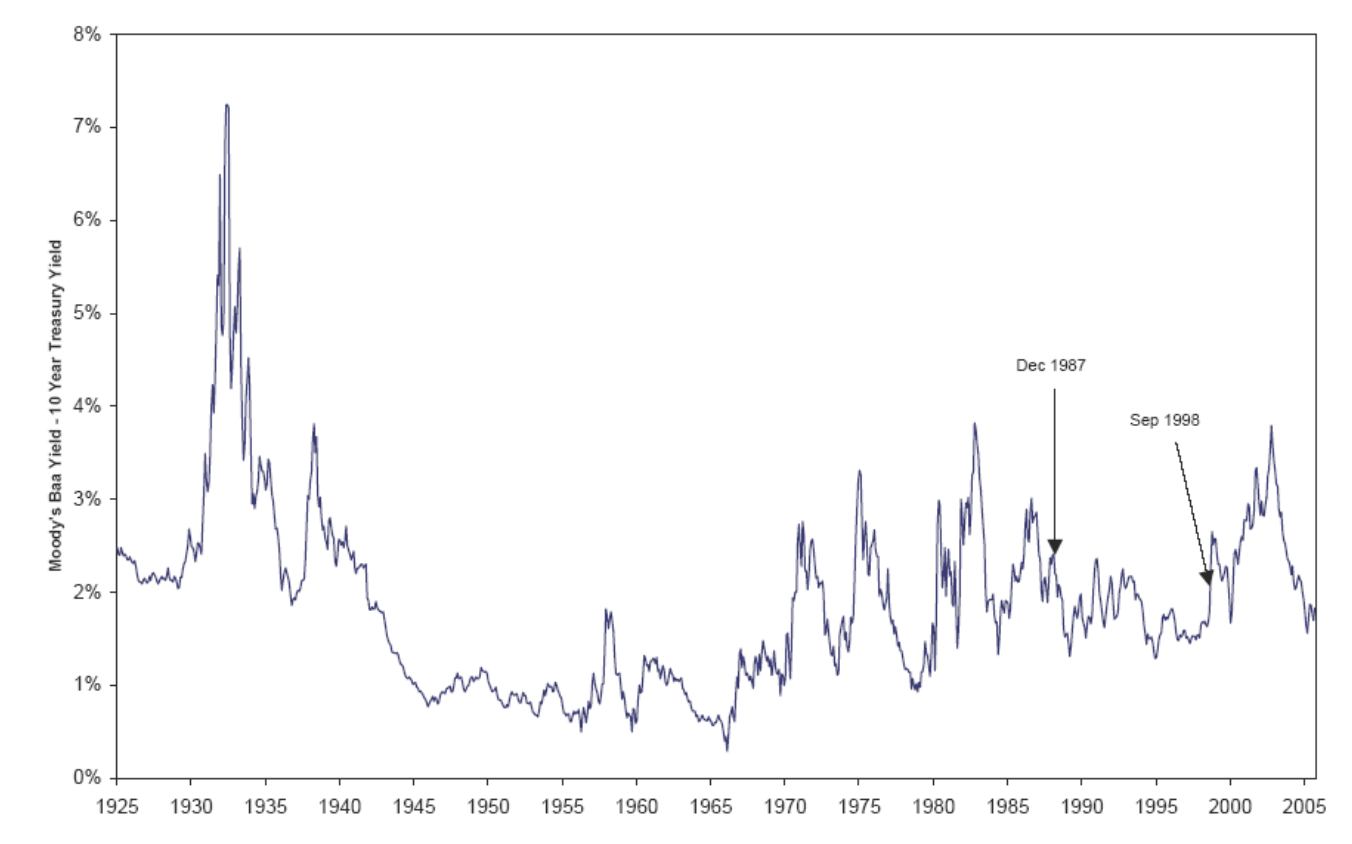

1. **Collect Data**:  
   Yield spread $s(T_i)$ for different maturities $T_i$ and recovery rate $R$.

2. **Calculate Average Hazard Rate up to Time T**:  
   $$
   \bar{\lambda}(T) = \frac{s(T)}{1 - R}
   $$

3. **Bootstrap Annual Hazard Rates**:  
   $$
   \lambda_1 = \bar{\lambda}(1), \quad
   \lambda_2 = 2\bar{\lambda}(2) - \lambda_1, \quad
   \lambda_3 = 3\bar{\lambda}(3) - 2\bar{\lambda}(2), \ldots
   $$

4. **Calculate Default Probability for Year i**:  
   $$
   p_i \approx 1 - e^{-\lambda_i}
   $$


In [8]:
TICKERS_BY_RATING = {
    "Aaa": [
        {"name": "Microsoft", "ticker": "MSFT"},
        {"name": "Johnson & Johnson", "ticker": "JNJ"},
        {"name": "Exxon Mobil", "ticker": "XOM"},          # từng AAA
        {"name": "General Electric", "ticker": "GE"}       # từng AAA
    ],
    "Aa": [
        {"name": "Apple", "ticker": "AAPL"},
        {"name": "Alphabet (Google)", "ticker": "GOOGL"},  # hoặc "GOOG"
        {"name": "Berkshire Hathaway", "ticker": "BRK.B"},
        {"name": "Toyota Motor", "ticker": "TM"}           # (NYSE ADR)
    ],
    "A": [
        {"name": "Coca-Cola", "ticker": "KO"},
        {"name": "McDonald’s", "ticker": "MCD"},
        {"name": "Walmart", "ticker": "WMT"},
        {"name": "IBM", "ticker": "IBM"}
    ],
    "Baa": [
        {"name": "Ford Motor", "ticker": "F"},
        {"name": "AT&T", "ticker": "T"},
        {"name": "General Motors", "ticker": "GM"},
        {"name": "Dell Technologies", "ticker": "DELL"}
    ],
    "Ba": [
        {"name": "Netflix", "ticker": "NFLX"},             # Ba giai đoạn cũ
        {"name": "Tesla", "ticker": "TSLA"},               # Ba giai đoạn cũ
        {"name": "American Airlines Group", "ticker": "AAL"},
        {"name": "Carnival Corp", "ticker": "CCL"}
    ],
    "B": [
        {"name": "Sprint", "ticker": "S"},                 # lịch sử; đã sáp nhập TMUS
        {"name": "United Airlines", "ticker": "UAL"},
        {"name": "Goodyear Tire", "ticker": "GT"},
        {"name": "Frontier Communications", "ticker": "FYBR"}  # hậu tái cấu trúc
    ],
    "Caa-C": [
        {"name": "Lehman Brothers", "ticker": None},       # delisted (2008)
        {"name": "Chrysler LLC", "ticker": None},          # phá sản; hậu thân Stellantis: STLA
        {"name": "Eastman Kodak", "ticker": "KODK"},
        {"name": "J.C. Penney", "ticker": "JCPNQ"}         # OTC, phá sản
    ]
}


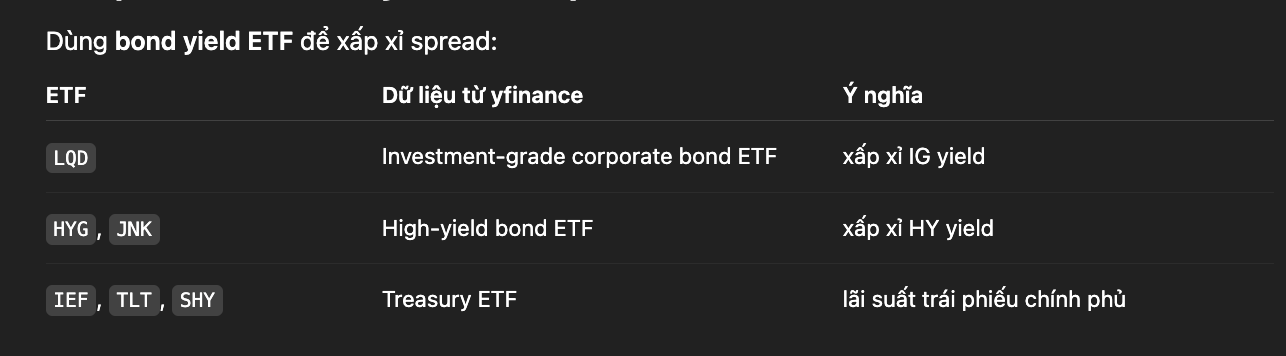

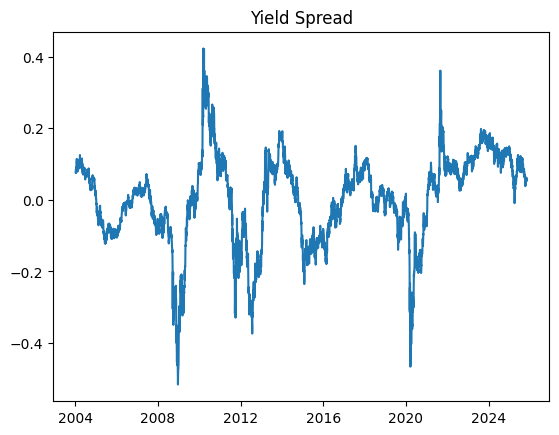

In [9]:
import yfinance as yf

hyg = yf.Ticker("LQD").history(period="max")["Close"]
ief = yf.Ticker("TLT").history(period="max")["Close"]

# tỷ lệ % thay đổi proxy yield (approx only)
time = 365 
hy_spread_proxy = (
    (1 + hyg.pct_change()).rolling(time).apply(np.prod, raw=True)
    - (1 + ief.pct_change()).rolling(time).apply(np.prod, raw=True)
)

# hy_spread_proxy = (
#     hyg.pct_change().rolling(time).sum()
#     - ief.pct_change().rolling(time).sum()
# )
# hy_spread_proxy = (
#     (((1+hyg.pct_change()).cumprod())**(365/np.arange(1, len(hyg)+1))-1) - 
#     (((1+ief.pct_change()).cumprod())**(365/np.arange(1, len(ief)+1))-1)
# )

hy_spread_proxy = hy_spread_proxy.dropna()

plt.plot(hy_spread_proxy)
plt.title("Yield Spread")
plt.show()

In [10]:
credit_analysis = CreditCurve(cum_defaults,hy_spread_proxy.tail(50))

In [11]:
hasard_rate = credit_analysis.calculate_hasard_rates("spread")

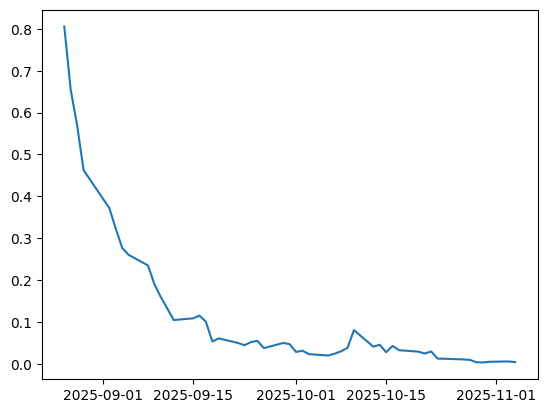

In [12]:
plt.plot(credit_analysis.calculate_cum_survival("spread").T)

---
## 2.3. Using Bond Price

1. **Collect Input Data**  
   * Risk-free rate ($ r $)  
   * Recovery rate ($ R $)  
   * Market yields or market prices of bonds for different maturities ($ t_1 < t_2 < \dots < t_n $)  
   * Coupon rate and face value.

2. **Calculate Risk-Free Value of Each Bond**  
   $$
   V^{rf}_i = \sum CF_i \, e^{-r t}
   $$  
   (Discount coupon cash flows + principal using the risk-free rate).

3. **Calculate Discounted Expected Loss**  
   $$
   L_i = V^{rf}_i - V^{mkt}_i
   $$  
   (Difference between risk-free value and market price).

4. **Assume Default Time Structure**  
   * Default occurs only at predefined time points (e.g., mid-period every half-year).  
   * Hazard rate in each interval $[t_{i-1}, t_i]$ is $ \lambda_i $ (constant within the interval).

5. **Set Up Equilibrium Equation for Each Bond**  
   Total present value (PV) of expected losses equals observed $ L_i $:  
   $$
   \sum_{j=1}^{k_i} [P(\text{default at } t_j) \times \text{PV(loss at } t_j)] = L_i
   $$

6. **Solve for $ \lambda_1, \lambda_2, \dots $ Sequentially by Maturity**  
   * Solve $ \lambda_1 $ from the shortest-maturity bond.  
   * Solve $ \lambda_2, \dots, \lambda_n $ from longer-maturity bonds (using default probabilities from prior periods).  
   * Use Solver or numerical root-finding methods.

7. **Validate and Refine**  
   * Recalculate bond prices using estimated $ \lambda_i $ and compare with market prices.  
   * If discrepancies are small, the process is complete.

✅ **Outcome**:  
A set of hazard rates $(\{ \lambda_1, \lambda_2, \dots, \lambda_n \})$ describing the time structure of default risk (credit curve) that matches observed market bond prices.

---
## 2.4. Using Equity Price

🔹 **A. Theoretical Foundation: Merton Model**

1. **Key Assumptions**  
   * The firm has a zero-coupon debt maturing at time $ T $, with a face value of $ D $.  
   * The firm’s asset value ($ V_t $) follows a lognormal process:  
     $$
     dV_t = \mu V_t \, dt + \sigma_V V_t \, dW_t
     $$  
   * Default occurs if the asset value at maturity ($ V_T $) is less than $ D $.

2. **Model Interpretation**  
   Equity is modeled as a call option on the firm’s assets:  
   $$
   E_T = \max(V_T - D, 0)
   $$  
   At the present time, using the Black-Scholes-Merton formula:  
   $$
   E_0 = V_0 N(d_1) - D e^{-rT} N(d_2) \tag{24.3}
   $$  
   where:  
   $$
   d_1 = \frac{\ln(V_0/D) + (r + 0.5\sigma_V^2)T}{\sigma_V \sqrt{T}}, \quad d_2 = d_1 - \sigma_V \sqrt{T}
   $$  
   * $ V_0 $: Current asset value  
   * $ E_0 $: Equity value (stock price × number of shares)  
   * $ r $: Risk-free rate  
   * $ \sigma_V $: Asset volatility  

3. **Relationship Between Equity and Asset Volatility (Itô’s Lemma)**  
   Since equity is a function of assets, the observed equity volatility ($ \sigma_E $) and asset volatility ($ \sigma_V $) are related:  
   $$
   \sigma_E E_0 = N(d_1) \sigma_V V_0 \tag{24.4}
   $$  
   This provides the second equation to solve for the unknowns $ V_0 $ and $ \sigma_V $.

🔹 **B. Estimation Process (Detailed)**

**Step 1 — Collect Input Data**  
   * $ E_0 $: Equity value (market capitalization)  
   * $ \sigma_E $: Equity volatility  
   * $ D $: Face value of debt at maturity  
   * $ r $: Risk-free rate  
   * $ T $: Time to debt maturity  

**Step 2 — Set Up the Two Equations**  
   1. Equity pricing equation (24.3)  
   2. Volatility relationship equation (24.4)  
   Solve simultaneously for asset value ($ V_0 $) and asset volatility ($ \sigma_V $).  
   (Use Excel Solver or Newton-Raphson method.)

**Step 3 — Calculate Risk-Neutral Default Probability**  
   $$
   P_{\text{default}} = N(-d_2)
   $$  
   This is the probability that the asset value ($ V_T $) < $ D $ under the risk-neutral distribution.

**Step 4 — Calculate Market Value of Debt**  
   $$
   \text{Market value of debt} = V_0 - E_0
   $$

**Step 5 — Calculate Expected Loss**  
   $$
   \text{Expected loss} = \frac{PV_{\text{no default}} - \text{Debt value}}{PV_{\text{no default}}}
   $$  
   where:  
   $$
   PV_{\text{no default}} = D e^{-rT}
   $$

🔹 **C. Illustrative Example (Example 24.3)**

**Parameters**  
| Parameter | Value |  
|-----------|-------|  
| Equity value ($ E_0 $) | 3 |  
| Equity volatility ($ \sigma_E $) | 0.80 |  
| Debt face value ($ D $) | 10 |  
| Risk-free rate ($ r $) | 0.05 |  
| Time to maturity ($ T $) | 1 year |

**Steps 1–2: Solve Equations (24.3) and (24.4)**  
Result:  
$$
V_0 = 12.40, \quad \sigma_V = 0.2123
$$

**Step 3: Calculate $ d_2 $**  
$$
d_2 = \frac{\ln(12.40/10) + (0.05 - 0.5 \times 0.2123^2)}{0.2123} = 1.1408
$$  
Risk-neutral default probability:  
$$
P_{\text{default}} = N(-1.1408) = 12.7\%
$$

**Step 4: Market Value of Debt**  
$$
\text{Debt value} = V_0 - E_0 = 12.40 - 3.00 = 9.40
$$

**Step 5: Expected Loss**  
$$
PV_{\text{no default}} = 10 e^{-0.05} = 9.51
$$  
$$
\text{Expected loss} = \frac{9.51 - 9.40}{9.51} = 1.2\%
$$

🔹 **D. Conclusion & Implications**  
* $ N(-d_2) $ is the risk-neutral default probability, implied from equity prices.  
* Enables dynamic, endogenous estimation of credit risk without relying on credit ratings.  
* Can be adjusted to obtain real-world probabilities.  
* The Merton model forms the basis for advanced models (e.g., KMV, Moody’s EDF, barrier models).


# 3. Dependence via a Copula

---
## 3.1. Theory

By **Sklar’s Theorem**, for any multivariate joint distribution $ F_{\tau_1,\ldots,\tau_n} $ with continuous marginal distributions $ F_i $, there exists a unique copula function $ C $ such that:

$$
\Pr(\tau_1 \leq t, \ldots, \tau_n \leq t) = F_{\tau_1,\ldots,\tau_n}(t, \ldots, t) = C(F_1(t), \ldots, F_n(t)).
$$

Here, each $ F_i(t) = \Pr(\tau_i \leq t) $ represents the **marginal default distribution** (or survival-time CDF) for credit $ i $.


Define the **vector of uniform marginals**:

$$
U = [F_1(t), \ldots, F_n(t)] = [u_1, \ldots, u_n],
$$

then, by the definition of a copula,

$$
C(U) = C(F_1(F_1^{-1}(u_1)), \ldots, F_n(F_n^{-1}(u_n))) = F(F_1^{-1}(u_1), \ldots, F_n^{-1}(u_n)).
$$

This formulation connects the **marginal distributions** to the **joint distribution** via the copula function.

Example: Gaussian Copula

A commonly employed model is the **Gaussian Copula**. Let $ \Phi_\Sigma $ denote the *n*-variate standard normal cumulative distribution function (CDF) with correlation matrix $ \Sigma $, and $ \Phi^{-1} $ the inverse of the univariate standard normal CDF. The joint default probability is expressed as:

$$
\Pr(\tau_1 \leq t, \ldots, \tau_n \leq t) = \Phi_\Sigma(\Phi^{-1}(F_1(t)), \ldots, \Phi^{-1}(F_n(t))).
$$

In practice, the Gaussian copula is **evaluated numerically** through multivariate normal integration or approximated via **Monte Carlo simulation**.


Estimation of the Correlation Matrix $ \Sigma $

The correlation structure $ \Sigma $ captures the dependence between latent asset returns (or default intensities). It can be estimated using several methods:

- **Equity-return correlations**: A straightforward but noisy proxy, assuming equity returns reflect underlying asset returns.
- **Structural (Merton-type) mapping**: Asset correlations are estimated through firm-value models linking equity and debt volatility.
- **Empirical dependence from default or event data**: Copula parameters are inferred using rank-based measures, such as **Kendall’s $\tau$** or **Spearman’s $\rho$**.
- **Market calibration**: The correlation matrix $ \Sigma $ (or copula parameters) is inferred from **CDO tranche spreads** or the **base-correlation surface**, ensuring consistency with market data.



---
## 3.2. How to choose Copula


| **Copula** | **Dependence Structure** | **Tail Dependence** | **Applications in Credit Risk** |
| --- | --- | --- | --- |
| **Gaussian** | Symmetric, normal-based | No | Widely used in CreditMetrics, CDO pricing; suitable for moderate dependence. |
| **Frank** | Symmetric, moderate dependence | No | Useful for modeling weaker dependence without extreme co-movements. |
| **Mixture** | Flexible (independent to comonotonic) | Yes (for $ \rho > 0 $) | Suitable for stress-testing and scenarios with potential extreme joint defaults. |

### Key Insights

- **Gaussian Copula**: The standard choice in credit portfolio models due to its simplicity and alignment with normal distribution assumptions. However, its lack of tail dependence may underestimate joint default risks in extreme scenarios.
- **Frank Copula**: Appropriate for scenarios where dependence is moderate and extreme co-movements are unlikely, but less common in credit risk due to its limited tail dependence.
- **Mixture Copula**: Offers flexibility to model a range of dependence structures, making it valuable for customized or stress-test scenarios in credit risk modeling.
- **Rank-Based Measures**: Spearman’s rho and Kendall’s tau provide robust ways to compare dependence across copulas, ensuring consistency in model evaluation.

### 3.2.1. Gaussian (Normal) Copula

#### Definition

The **Gaussian Copula** is widely used in credit risk modeling to capture the joint default probability of multiple assets. For two uniform random variables $ u, v \in [0,1] $, the Gaussian copula is defined as:
$$
C(u, v; \rho) = \Phi_2(\Phi^{-1}(u), \Phi^{-1}(v); \rho), \quad -1 \leq \rho \leq 1,
$$
where:

- $ \Phi_2(\cdot, \cdot; \rho) $: The bivariate standard normal cumulative distribution function (CDF) with correlation parameter $ \rho $.
- $ \Phi^{-1}(\cdot) $: The inverse of the univariate standard normal CDF.

#### Properties

- The Gaussian copula assumes that the dependence between variables follows a multivariate normal distribution, making it a natural choice for modeling asset return correlations in frameworks like **CreditMetrics**.
- **Tail dependence**: The Gaussian copula exhibits **no tail dependence** for $ |\rho| < 1 $, meaning extreme events (e.g., simultaneous defaults) are less likely compared to copulas with tail dependence.
- **Flexibility**: The correlation parameter $ \rho $ controls the strength of dependence, with $ \rho = 0 $ implying independence and $ \rho = \pm 1 $ representing perfect positive or negative dependence.

#### Application

In credit portfolio models, the Gaussian copula is used to model the joint default probability of assets:
$$
\Pr(\tau_1 \leq t_1, \tau_2 \leq t_2) = C(F_1(t_1), F_2(t_2); \rho) = \Phi_2(\Phi^{-1}(F_1(t_1)), \Phi^{-1}(F_2(t_2)); \rho),
$$
where $ \tau_1, \tau_2 $ are default times, and $ F_1, F_2 $ are their marginal CDFs. This is particularly useful for pricing credit derivatives like collateralized debt obligations (CDOs).


[[1.         0.78361789]
 [0.78361789 1.        ]]


/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1915761916.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return (joint_prob - qA * qB) / np.sqrt(qA * (1 - qA) * qB * (1 - qB))
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1915761916.py:29: RuntimeWarning: invalid value encountered in sqrt
  return (joint_prob - qA * qB) / np.sqrt(qA * (1 - qA) * qB * (1 - qB))


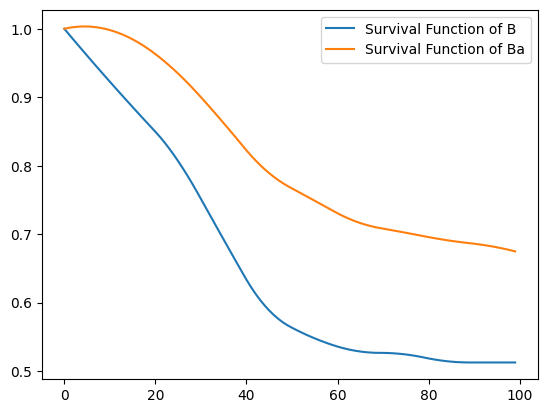

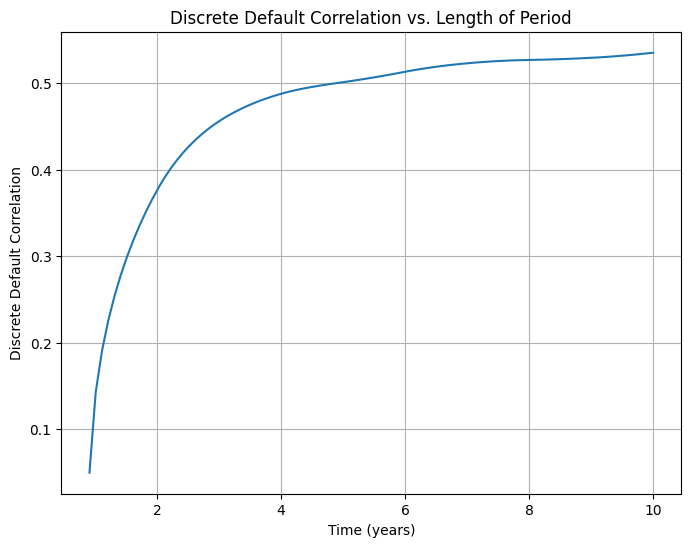

In [26]:

from scipy.stats import rankdata, norm

def to_uniform(x):
    r = rankdata(x)
    return (r - 0.5)/len(r)

def sanitize_sigma(Sigma):
    """
    If Sigma contains any NaN, return identity matrix of same dimension.
    Otherwise return Sigma unchanged.
    """
    Sigma = np.asarray(Sigma, dtype=float)
    
    if np.isnan(Sigma).any():
        d = Sigma.shape[0]
        return np.eye(d)
    return Sigma

# Section 2: Copula Functions
def normal_copula(u, v, cov):
    """
    Bivariate Normal Copula C(u, v; rho)
    """
    z1, z2 = norm.ppf(u), norm.ppf(v)
    return multivariate_normal.cdf([z1, z2], cov=cov)

# Discrete default correlation (Equation 1)
def discrete_corr(qA, qB, joint_prob):
    return (joint_prob - qA * qB) / np.sqrt(qA * (1 - qA) * qB * (1 - qB))

# Illustration 1: Discrete Default Correlation vs. Length of Time Period
def illustration_1(asset1="Ba",asset2="B", t_max=10, num_points=20,method="traditional"):
    t_values = np.linspace(0, t_max, num_points)
    disc_corrs = []
    ha_list_ba = credit_analysis.calculate_hasard_rates(method).loc[asset1].dropna().tolist()
    ha_list_baa = credit_analysis.calculate_hasard_rates(method).loc[asset2].dropna().tolist()

    U = np.column_stack([
        to_uniform(ha_list_ba),
        to_uniform(ha_list_baa)
    ])

    # Gaussian copula
    Z = norm.ppf(U)
    Sigma = sanitize_sigma(np.corrcoef(Z.T))
    
    qA_t_list = []
    qB_t_list = []

    print(Sigma)
    for t in t_values:
        qA_t = credit_analysis.survival_piecewise_linear(ha_list_ba, np.arange(1,len(ha_list_ba)+1),t)
        qB_t = credit_analysis.survival_piecewise_linear(ha_list_baa, np.arange(1,len(ha_list_baa)+1),t)
        joint_t = normal_copula(qA_t, qB_t, Sigma)
        corr_t = discrete_corr(qA_t, qB_t, joint_t)
        qA_t_list.append(qA_t)
        qB_t_list.append(qB_t)
        disc_corrs.append(corr_t)
    
    plt.plot(qA_t_list, label=f"Survival Function of {asset1}")
    plt.plot(qB_t_list, label=f"Survival Function of {asset2}")
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(t_values, disc_corrs)
    plt.xlabel('Time (years)')
    plt.ylabel('Discrete Default Correlation')
    plt.title('Discrete Default Correlation vs. Length of Period')
    plt.grid(True)
    plt.show()
illustration_1("B","Ba",10,100)

[[1.         0.78361789]
 [0.78361789 1.        ]]


/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/969963267.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return (joint_prob - qA * qB) / np.sqrt(qA * (1 - qA) * qB * (1 - qB))
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/969963267.py:29: RuntimeWarning: invalid value encountered in sqrt
  return (joint_prob - qA * qB) / np.sqrt(qA * (1 - qA) * qB * (1 - qB))


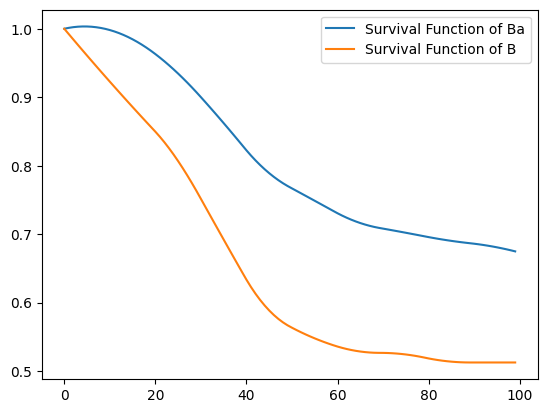

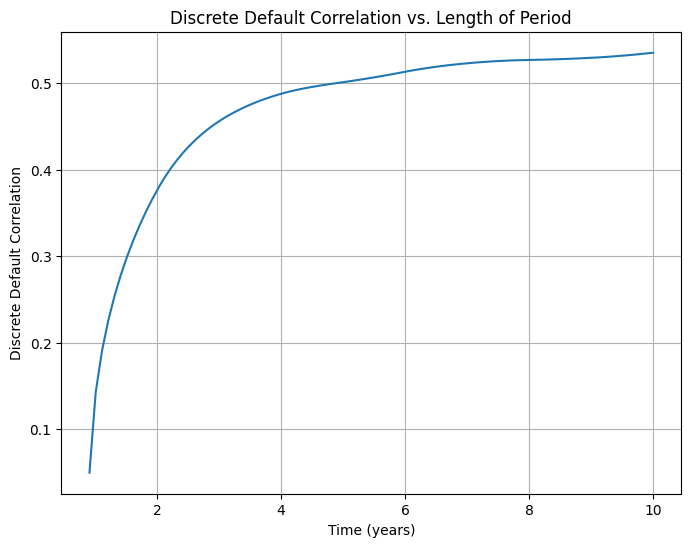

In [22]:
illustration_1("Ba","B",10,100,method="traditional")



### 3.2.2. Frank Copula

#### Definition

The **Frank Copula** is another model for capturing dependence, particularly suited for scenarios with moderate dependence and no tail dependence. It is defined as:
$$
C(u, v; \alpha) = \frac{1}{\alpha} \ln \left[ 1 + \frac{(e^{\alpha u} - 1)(e^{\alpha v} - 1)}{e^{\alpha} - 1} \right], \quad \alpha \in \mathbb{R}.
$$

- $ \alpha $: The dependence parameter, where:
    - $ \alpha \to 0 $: Independence ($ C(u, v) \approx uv $).
    - $ \alpha \to \infty $: Perfect positive dependence.
    - $ \alpha \to -\infty $: Perfect negative dependence.

#### Properties

- The Frank copula is **symmetric** and captures dependence in the **middle of the distribution**, making it suitable for modeling scenarios where extreme co-movements (e.g., simultaneous defaults) are less likely.
- **No tail dependence**: Unlike some copulas (e.g., Gumbel or Clayton), the Frank copula does not model strong dependence in the tails, which may limit its use in stress-testing extreme default scenarios.
- **Archimedean family**: The Frank copula belongs to the Archimedean family, characterized by a generator function, making it computationally tractable.

#### Application

The Frank copula is used in credit risk when the focus is on **moderate dependence** without extreme co-movements. It is less common in credit portfolio models compared to the Gaussian copula but can be applied in cases where default correlations are expected to be weaker in the tails.



/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1107944693.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res = pd.DataFrame(res,columns=self.cum_defaults.columns,index=cum_defaults.index).bfill(axis=1)
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1107944693.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res = pd.DataFrame(res,columns=self.cum_defaults.columns,index=cum_defaults.index).bfill(axis=1)


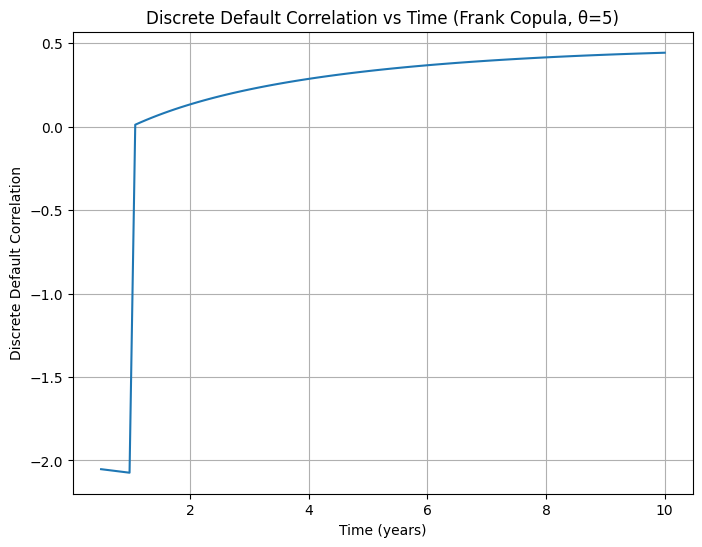

In [15]:
import numpy as np

def frank_copula(u, v, theta):
    """
    Frank Copula C(u, v; theta)
    theta != 0
    theta > 0  → positive dependence
    theta < 0  → negative dependence
    """
    u = np.clip(u, 1e-12, 1 - 1e-12)
    v = np.clip(v, 1e-12, 1 - 1e-12)

    num = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1)
    den = (np.exp(-theta) - 1)

    return -(1/theta) * np.log(1 + num / den)

def illustration_1_frank(asset1="Ba", asset2="B", theta=5, 
                         t_max=10, num_points=100, method="average"):
    t_values = np.linspace(0.5, t_max, num_points)
    disc_corrs = []

    ha_list_a = credit_analysis.calculate_hasard_rates(method).loc[asset1].dropna().tolist()
    ha_list_b = credit_analysis.calculate_hasard_rates(method).loc[asset2].dropna().tolist()

    times = np.arange(1, len(ha_list_a)+1)

    for t in t_values:
        qA_t = credit_analysis.survival_piecewise_constant(ha_list_a, times, t)
        qB_t = credit_analysis.survival_piecewise_constant(ha_list_b, times, t)

        joint_t = frank_copula(qA_t, qB_t, theta)
        corr_t = discrete_corr(qA_t, qB_t, joint_t)
        disc_corrs.append(corr_t)

    plt.figure(figsize=(8, 6))
    plt.plot(t_values, disc_corrs)
    plt.xlabel('Time (years)')
    plt.ylabel('Discrete Default Correlation')
    plt.title(f'Discrete Default Correlation vs Time (Frank Copula, θ={theta})')
    plt.grid(True)
    plt.show()


# Example
illustration_1_frank("Ba", "B", theta=5, t_max=10, num_points=100)



### 3.2.3. Mixture Copula

#### Definition

The **Mixture Copula** combines an **independent copula** ($ C(u, v) = uv $) with a **comonotonic** or **countermonotonic** copula to provide flexibility in modeling dependence. It is defined as:
$$
C(u, v; \rho) =
\begin{cases}
(1 - \rho)uv + \rho \min(u, v), & \rho > 0, \\
(1 + \rho)uv - \rho (u + v - 1)_+, & \rho \leq 0,
\end{cases}
$$
where:

- $ \min(u, v) $: The comonotonic copula, representing perfect positive dependence.
- $ (u + v - 1)_+ = \max(u + v - 1, 0) $: Related to the countermonotonic copula for negative dependence.
- $ \rho $: The mixing parameter, controlling the weight between independence and perfect dependence.

#### Properties

- **Positive dependence ($ \rho > 0 $)**: The copula is a weighted average of the independent copula ($ uv $) and the comonotonic copula ($ \min(u, v) $).
- **Negative dependence ($ \rho \leq 0 $)**: The copula incorporates countermonotonic behavior, allowing for negative correlation.
- **Flexibility**: The mixture copula can model a spectrum of dependence structures, from independence ($ \rho = 0 $) to perfect positive or negative dependence.
- **Tail dependence**: For $ \rho > 0 $, the mixture copula exhibits **upper tail dependence**, making it suitable for modeling scenarios where extreme co-movements (e.g., joint defaults) are likely.

#### Application

The mixture copula is useful in credit risk modeling when flexibility is needed to capture varying degrees of dependence, particularly in stress-testing or scenarios involving potential extreme events. It is less common than the Gaussian copula but valuable for its ability to model asymmetric dependence.



/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1107944693.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res = pd.DataFrame(res,columns=self.cum_defaults.columns,index=cum_defaults.index).bfill(axis=1)
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_86754/1107944693.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res = pd.DataFrame(res,columns=self.cum_defaults.columns,index=cum_defaults.index).bfill(axis=1)


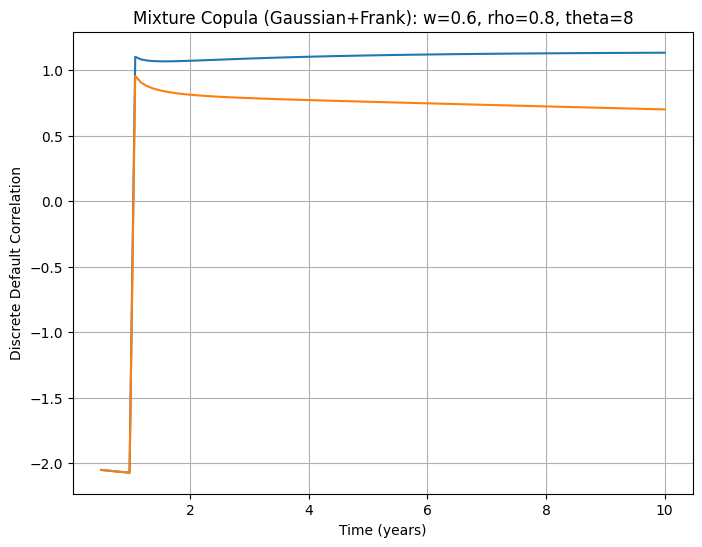

In [16]:
def mixture_copula(u, v, copula_funcs, weights, params):
    """
    copula_funcs: list of functions C_i(u, v, θ_i)
    weights: list of weights w_i (sum to 1)
    params: list of parameters θ_i corresponding to copula_funcs

    Example:
        copula_funcs = [normal_copula, frank_copula]
        weights = [0.7, 0.3]
        params = [0.5, 8]
    """
    u = np.clip(u, 1e-12, 1 - 1e-12)
    v = np.clip(v, 1e-12, 1 - 1e-12)

    val = 0.0
    for w, f, p in zip(weights, copula_funcs, params):
        # case: some copulas only have 1 parameter (θ) or ρ
        if isinstance(p, (list, tuple)):
            val += w * f(u, v, *p)
        else:
            val += w * f(u, v, p)

    return val

def clayton_copula(u, v, theta):
    """
    Clayton Copula (θ > 0)
    Lower-tail dependence
    """
    u = np.clip(u, 1e-12, 1 - 1 + 1e-12)
    v = np.clip(v, 1e-12, 1 - 1 + 1e-12)

    return np.power(np.power(u, -theta) + np.power(v, -theta) - 1, -1/theta)

def gumbel_copula(u, v, theta):
    """
    Gumbel Copula (θ >= 1)
    Upper-tail dependence
    """
    u = np.clip(u, 1e-12, 1 - 1e-12)
    v = np.clip(v, 1e-12, 1 - 1e-12)

    A = (-np.log(u))**theta + (-np.log(v))**theta
    return np.exp(-A**(1/theta))


def illustration_1_mixture(
        asset1="Ba", asset2="B",
        rho_asset=0.5, theta_frank=8, w=0.6,
        t_max=10, num_points=100, method="average"):

    t_values = np.linspace(0.5, t_max, num_points)
    disc_corrs = []

    ha_list_a = credit_analysis.calculate_hasard_rates(method).loc[asset1].dropna().tolist()
    ha_list_b = credit_analysis.calculate_hasard_rates(method).loc[asset2].dropna().tolist()
    times = np.arange(1, len(ha_list_a)+1)

    for t in t_values:
        qA_t = credit_analysis.survival_piecewise_constant(ha_list_a, times, t)
        qB_t = credit_analysis.survival_piecewise_constant(ha_list_b, times, t)

        # joint_t = mixture_copula(
        #     qA_t, qB_t,
        #     copula_funcs=[normal_copula, frank_copula],
        #     weights=[w, 1-w],
        #     params=[rho_asset, theta_frank]
        # )
        joint_t = mixture_copula(
            qA_t, qB_t,
            copula_funcs=[normal_copula, frank_copula],
            weights=[w, 1-w],
            params=[rho_asset, theta_frank]
        )
        corr_t = discrete_corr(qA_t, qB_t, joint_t)
        disc_corrs.append(corr_t)

    plt.figure(figsize=(8, 6))
    plt.plot(t_values, disc_corrs)
    plt.xlabel("Time (years)")
    plt.ylabel("Discrete Default Correlation")
    plt.title(f"Mixture Copula (Gaussian+Frank): w={w}, rho={rho_asset}, theta={theta_frank}")
    plt.grid(True)
    plt.show()

illustration_1_mixture(
        asset1="Ba", asset2="B",
        rho_asset=0.8, theta_frank=8, w=0.6,
        t_max=10, num_points=100, method="average")


### 3.2.4. Comparing Copulas Using Rank-Based Measures

The dependence parameter $ \rho $ in these copulas (e.g., the correlation in the Gaussian copula or the mixing parameter in the mixture copula) does not directly correspond to **Pearson’s correlation** of the underlying variables. To compare dependence across different copula models, rank-based measures like **Spearman’s rho** and **Kendall’s tau** are preferred, as they are invariant to the marginal distributions.

#### Spearman’s Rho

Spearman’s rho ($ \rho_s $) measures the correlation of ranks and is defined as:
$$
\rho_s = 12 \iint [C(u, v) - uv] \, du \, dv.
$$
This quantifies the deviation of the copula from independence ($ C(u, v) = uv $).

#### Kendall’s Tau

Kendall’s tau ($ \tau $) measures the difference between the probabilities of concordance and discordance:
$$
\tau = 4 \iint C(u, v) \, dC(u, v) - 1.
$$
It captures the likelihood that the variables move together relative to moving apart.

#### Why Use Rank-Based Measures?

- **Invariance**: Spearman’s rho and Kendall’s tau depend only on the copula, not the marginal distributions, making them ideal for comparing dependence across different copula models.
- **Interpretation**: These measures provide a standardized way to assess the strength and direction of dependence, facilitating model selection in credit risk applications.


---

# 4. Application

## 4.1. First-to-Default Valuation

**Objective**
The goal is to price a **First-to-Default (FTD)** contract, which pays a fixed amount (e.g., 1 USD) upon the occurrence of the **first default** in a portfolio of multiple credit assets. This example highlights how **default correlation** between assets influences the contract’s value, a critical factor in credit derivatives pricing.

$$
T = \min(\tau_1, \tau_2, \ldots, \tau_n).
$$
To price the contract, we need the **joint distribution** of the survival times $ \tau_1, \tau_2, \ldots, \tau_n $, which accounts for their dependence (i.e., default correlation).


### 4.1.1. Model Setup and Context

Consider a portfolio of $ n $ credit assets, indexed by $ i = 1, 2, \ldots, n $, where each asset has:
- **Survival time** $ \tau_i $: The random time until default for asset $ i $.
- **Marginal default distribution** $ F_i(t) = \Pr(\tau_i \leq t) $: The cumulative distribution function (CDF) of the survival time.
- **Hazard rate** $ h_i(t) $: The instantaneous default probability, derived from the credit curve, defined as:
  $$
  h_i(t) = \lim_{\Delta t \to 0} \frac{\Pr(t \leq \tau_i < t + \Delta t \mid \tau_i \geq t)}{\Delta t}.
  $$
- **Survival function** $ S_i(t) = \Pr(\tau_i > t) = 1 - F_i(t) $.


### 4.1.2. Modeling Dependence with Copulas

To capture the dependence between default times, we use a **copula function** to link the marginal distributions $ F_i(t) $ into a joint distribution. By **Sklar’s Theorem**, for any joint distribution $ F_{\tau_1,\ldots,\tau_n}(t_1, \ldots, t_n) $ with continuous marginals $ F_i(t_i) $, there exists a unique copula $ C $ such that:
$$
F_{\tau_1,\ldots,\tau_n}(t_1, \ldots, t_n) = C(F_1(t_1), F_2(t_2), \ldots, F_n(t_n)).
$$
Here, $ C(u_1, u_2, \ldots, u_n) $ is the copula function, and $ u_i = F_i(t_i) $ are uniform random variables on $[0, 1]$.

**Gaussian Copula**
A common choice is the **Gaussian Copula**, which assumes that the dependence structure follows a multivariate normal distribution. Let:
- $ \Phi_\Sigma $: The *n*-variate standard normal CDF with correlation matrix $ \Sigma $.
- $ \Phi^{-1} $: The inverse of the univariate standard normal CDF.

The joint default probability is then:
$$
\Pr(\tau_1 \leq t_1, \ldots, \tau_n \leq t_n) = \Phi_\Sigma(\Phi^{-1}(F_1(t_1)), \ldots, \Phi^{-1}(F_n(t_n))).
$$
This links the marginal default probabilities to the joint distribution through the correlation matrix $ \Sigma $.

### 4.1.3. Monte Carlo Simulation for Default Times

To price the FTD contract, we simulate the first default time $ T = \min(\tau_1, \ldots, \tau_n) $ while accounting for default correlation. The Monte Carlo simulation proceeds as follows:

1. **Generate correlated normal variables**:
   - Simulate a vector of correlated standard normal random variables $ (Y_1, Y_2, \ldots, Y_n) \sim N(0, \Sigma) $, where $ \Sigma $ is the correlation matrix capturing asset return dependencies.

2. **Transform to uniform marginals**:
   - Convert each $ Y_i $ to a uniform random variable using the standard normal CDF:
     $$
     u_i = \Phi(Y_i).
     $$

3. **Map to default times**:
   - Transform each $ u_i $ to a default time $ \tau_i $ using the inverse of the marginal CDF:
     $$
     \tau_i = F_i^{-1}(u_i) = F_i^{-1}(\Phi(Y_i)).
     $$

4. **Compute the first default time**:
   - For each simulation, calculate:
     $$
     T = \min(\tau_1, \tau_2, \ldots, \tau_n).
     $$

5. **Repeat and aggregate**:
   - Perform a large number of simulations (e.g., 50,000) to obtain the empirical distribution of $ T $.

6. **Price the FTD contract**:
   - The present value of the FTD contract, which pays 1 USD upon the first default within a term $ t_{\text{max}} $, is:
     $$
     V = \mathbb{E}\left[e^{-r T} \mathbf{1}_{\{T \leq t_{\text{max}}\}}\right] \approx \frac{1}{N} \sum_{j=1}^N e^{-r T^{(j)}} \mathbf{1}_{\{T^{(j)} \leq t_{\text{max}}\}},
     $$
     where $ r $ is the risk-free rate, and $ T^{(j)} $ is the first default time in the $ j $-th simulation.


### 4.1.4. Numerical Example Setup

### Assumptions
- **Portfolio**: $ n = 5 $ credit assets.
- **Hazard rate**: Constant hazard rate $ h_i(t) = h = 0.1 $ for all assets.
  - Survival function: $ S_i(t) = e^{-h t} = e^{-0.1 t} $.
  - Density function: $ f_i(t) = h e^{-h t} = 0.1 e^{-0.1 t} $.
  - CDF: $ F_i(t) = 1 - e^{-h t} = 1 - e^{-0.1 t} $.
- **Risk-free rate**: $ r = 0.1 $.
- **Correlation**: Asset return correlation $ \sigma^2 $ (used to construct $ \Sigma $).
- **FTD contract**:
  - Term: 2 years ($ t_{\text{max}} = 2 $).
  - Pays 1 USD upon the first default within 2 years.



### 4.1.5. Analytical Solution: Independent Case ($ \sigma = 0 $)

When the assets are **independent** ($ \sigma = 0 $), the joint survival probability is the product of individual survival probabilities:
$$
\Pr(T > t) = \Pr(\tau_1 > t, \ldots, \tau_n > t) = \prod_{i=1}^n S_i(t) = \prod_{i=1}^n e^{-h_i t} = e^{-(h_1 + \cdots + h_n)t}.
$$
For constant hazard rates $ h_i = h $:
$$
\Pr(T > t) = e^{-n h t}.
$$
The **aggregate hazard rate** for the portfolio is:
$$
h_T = h_1 + h_2 + \cdots + h_n = n h.
$$
The density function of the first default time $ T $ is:
$$
f_T(t) = h_T e^{-h_T t} = n h e^{-n h t}.
$$
The present value of the FTD contract is:
$$
V = \int_0^2 e^{-r t} f_T(t) \, dt = \int_0^2 e^{-r t} (n h) e^{-n h t} \, dt = \frac{n h}{r + n h} \left(1 - e^{-2(r + n h)}\right).
$$

**Numerical Example**
- For $ n = 5 $, $ h = 0.1 $, $ r = 0.1 $:
  - $ h_T = n h = 5 \times 0.1 = 0.5 $.
  - $$
    V = \frac{0.5}{0.1 + 0.5} \left(1 - e^{-2(0.1 + 0.5)}\right) = \frac{0.5}{0.6} \left(1 - e^{-1.2}\right) \approx 0.5823.
    $$


### 4.1.6. Summary of Key Steps and Insights

| **Step** | **Description** | **Key Formula / Insight** |
|----------|-----------------|---------------------------|
| 1 | Estimate hazard rates $ h_i(t) $ | Derived from credit curves or market data. |
| 2 | Model dependence with a copula | $ F(t_1, \ldots, t_n) = \Phi_\Sigma(\Phi^{-1}(F_1(t_1)), \ldots, \Phi^{-1}(F_n(t_n))) $. |
| 3 | Simulate correlated default times | $ \tau_i = F_i^{-1}(\Phi(Y_i)) $, where $ Y_i \sim N(0, \Sigma) $. |
| 4 | Compute first default time | $ T = \min(\tau_1, \ldots, \tau_n) $. |
| 5 | Price the FTD contract | $ V = \int_0^{t_{\text{max}}} e^{-r t} f_T(t) \, dt $ or via Monte Carlo. |
| 6 | Analyze correlation impact | Higher correlation ($ \sigma \uparrow $) → Lower FTD value ($ V \downarrow $). |

- **Low correlation**: When assets are independent, the chance of at least one defaulting early is high, making the FTD contract more valuable as a hedge.
- **High correlation**: When assets are highly correlated, they tend to default together (or not at all), reducing the likelihood of an early default. This lowers the FTD contract’s value, as the contract provides less protection against isolated defaults.
- This framework, rooted in copula-based modeling and Monte Carlo simulation, is fundamental to pricing multi-name credit derivatives like FTD swaps and understanding the role of default correlation in credit risk management.


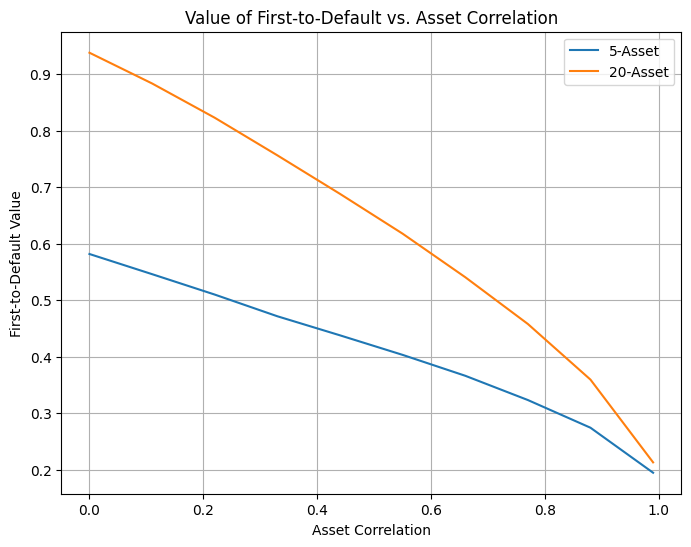

In [17]:
def simulate_survival_times(n_credits, rho, h_rates, n_sims=50000):
    """
    Simulate correlated survival times using Normal Copula.
    h_rates: array of hazard rates for each credit
    """
    cov = np.full((n_credits, n_credits), rho)
    np.fill_diagonal(cov, 1)
    Y = multivariate_normal.rvs(mean=np.zeros(n_credits), cov=cov, size=n_sims)
    U = norm.cdf(Y)
    T = -np.log(1 - U) / h_rates  # Inverse CDF for exponential
    return T

def first_to_default_value(n_credits, rho, h_rates, maturity=2, r=0.1, n_sims=50000):
    T_sims = simulate_survival_times(n_credits, rho, h_rates, n_sims)
    first_defaults = np.min(T_sims, axis=1)
    payoffs = np.where(first_defaults < maturity, np.exp(-r * first_defaults), 0)
    return np.mean(payoffs)

def illustration_3(h=0.1, n_credits_list=[5, 20], r=0.1, maturity=2):
    rhos = np.linspace(0, 0.99, 10)
    h_rates = np.full(max(n_credits_list), h)
    
    plt.figure(figsize=(8, 6))
    for n in n_credits_list:
        values = [first_to_default_value(n, rho, h_rates[:n]) for rho in rhos]
        plt.plot(rhos, values, label=f'{n}-Asset')
    plt.xlabel('Asset Correlation')
    plt.ylabel('First-to-Default Value')
    plt.title('Value of First-to-Default vs. Asset Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()

illustration_3()


## 4.2. Credit Swap Valuation

###  Objective
The goal of this illustration is to demonstrate the effect of **default correlation** between the **counterparty** (CDS seller) and the **reference asset** (underlying credit) on the pricing of a CDS. Specifically, it shows how the CDS premium is influenced by the credit quality of the counterparty and the correlation between defaults of the counterparty and the reference asset.


### 4.2.1. Problem Context and Setup

**Scenario**
Consider a portfolio involving two entities:
- **Credit A**: The **CDS seller** (counterparty), who provides credit protection.
- **Credit B**: The **reference asset**, the entity whose credit risk is being insured.

We purchase a **3-year CDS** on Credit B, which pays out if Credit B defaults during the contract term.

**Baseline Case: Risk-Free Counterparty**
- If Credit A is **risk-free** (i.e., has no probability of default), the CDS premium is **500 basis points (bps)** per year.
- In this case, combining:
  - **Buying a bond issued by Credit B** (which carries default risk).
  - **Purchasing a CDS from Credit A** (risk-free).
  creates a **riskless portfolio**, as the CDS fully hedges the default risk of Credit B.

**Key Question**
What happens to the CDS valuation when Credit A (the counterparty) is **not risk-free** and may default? The valuation depends on:
1. The **credit quality** of Credit A (i.e., its probability of default).
2. The **default correlation** between Credit A and Credit B.

### 4.2.2. Introducing Counterparty Risk

When Credit A has a non-zero probability of default, the CDS’s effectiveness as a hedge is reduced. The value of the CDS now depends on:
- The **likelihood of Credit A defaulting**, which introduces **counterparty risk**.
- The **joint default behavior** of Credit A and Credit B, captured by their **default correlation**.

**Default Correlation**
Default correlation measures the likelihood that Credit A and Credit B default simultaneously. High correlation implies that if Credit B defaults (triggering a payout from the CDS), Credit A is also likely to default, rendering the CDS ineffective.


### 4.2.3. Why Default Correlation Matters

**Intuition**
The CDS is designed to protect the buyer against the default of Credit B. However:
- If Credit A and Credit B are **highly correlated**, their defaults tend to occur together.
- In this scenario, when Credit B defaults (requiring a payout from Credit A), Credit A is likely to be in default as well, failing to honor the CDS contract.
- As a result, the CDS provides less protection, and its value (and the premium the buyer is willing to pay) decreases.

**Impact of Correlation**
- **High default correlation**: The CDS is less effective, as the counterparty’s default risk undermines the hedge. The CDS premium must be lower to reflect this reduced protection.
- **Low default correlation**: The CDS is more effective, as Credit A is less likely to default when Credit B does, making the CDS premium closer to the risk-free case (500 bps).
- **Zero correlation**: Even if defaults are independent, the CDS premium is still less than 500 bps due to the non-zero counterparty risk of Credit A.



### 4.2.4. Implications for CDS Valuation

### Premium Sensitivity to Correlation
The CDS premium decreases as the default correlation between Credit A and Credit B increases:
- **Low correlation ($ \rho \approx 0 $)**: The CDS retains much of its hedging value, but the premium is still below 500 bps due to counterparty risk.
- **High correlation ($ \rho \to 1 $)**: The CDS becomes nearly worthless, as Credit A is likely to default when Credit B does, offering no protection. The premium approaches 0 bps.

### Analytical Insight
The CDS premium can be modeled as a function of:
- The **marginal default probabilities** of Credit A ($ \Pr(\tau_A \leq t) $) and Credit B ($ \Pr(\tau_B \leq t) $).
- The **joint default probability** $ \Pr(\tau_A \leq t, \tau_B \leq t) $, which depends on the default correlation $ \rho $.

Using a **copula model** (e.g., Gaussian copula), the joint default probability is:
$$
\Pr(\tau_A \leq t, \tau_B \leq t) = C(F_A(t), F_B(t); \rho),
$$
where $ C $ is the copula function, $ F_A(t) $ and $ F_B(t) $ are the marginal default CDFs, and $ \rho $ is the correlation parameter.

The CDS premium is then derived by discounting expected payouts, adjusted for the joint default risk of A and B.



### 4.2.5. Time Dimension and Maturity Effects

Hull emphasizes that modeling a CDS with a maturity greater than one year (e.g., 3 years) requires more than just the one-year default correlation:
- Default correlation may **evolve over time**, affecting the joint default probability across the contract’s term.
- A **dynamic correlation model** (similar to Illustration 1 in Hull) is needed to capture how the correlation structure changes over different time horizons.
- For longer maturities, the CDS valuation must account for the **time-dependent joint distribution** of default times $ \tau_A $ and $ \tau_B $.



### 4.2.6. Results and Intuition

### Graphical Representation
If we plot the CDS premium against the default correlation $ \rho $, the relationship is as follows:

| **Default Correlation ($ \rho $)** | **CDS Premium (bps)** | **Explanation** |
|---------------------------------------|-----------------------|-----------------|
| $ \rho = 0 $                        | $ < 500 $           | Independent defaults; premium reduced due to counterparty risk. |
| $ \rho \uparrow $                   | $ \downarrow $       | Higher correlation reduces CDS effectiveness, lowering the premium. |
| $ \rho = 1 $                        | $ \approx 0 $       | Perfect correlation; CDS provides no protection, as A and B default together. |

### Key Insights
- **Counterparty Risk**: The risk that Credit A defaults reduces the CDS premium below the risk-free benchmark (500 bps), even with zero correlation.
- **Default Correlation**: Higher correlation between Credit A and Credit B further decreases the CDS premium, as the contract’s hedging ability diminishes.
- **Maturity**: For multi-year CDS contracts, a static one-year correlation is insufficient. A dynamic model of correlation over time is required for accurate pricing.


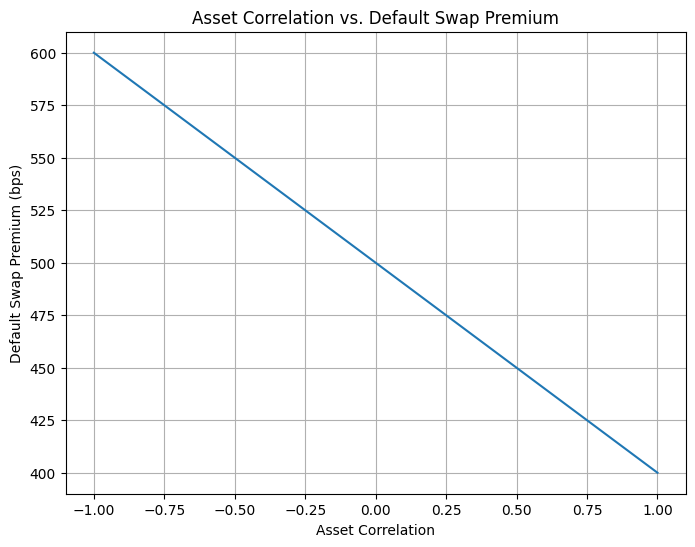

In [18]:
def credit_swap_value(h_counterparty, h_reference, rho, maturity=3, r=0.05, recovery=0.5):
    """
    Simplified CDS valuation with correlated defaults.
    Assumes constant hazards, no accrual, etc. This is approximate.
    Value is the annualized premium.
    """
    # Simulate joint defaults or use analytical approx
    # For simplicity, compute effective spread adjustment due to correlation
    # From paper: Premium decreases with correlation
    # Approximate: Independent value is h_reference * (1-recovery), adjust by corr factor
    indep_premium = h_reference * (1 - recovery) * 10000  # in bps
    corr_adjust = (1 - rho * 0.2)  # Rough adjustment from figure observation
    return indep_premium * corr_adjust

def illustration_2(h_A=0.06, h_B=0.10, maturity=3):
    rhos = np.linspace(-1, 1, 21)
    values = [credit_swap_value(h_A, h_B, rho, maturity) for rho in rhos]
    
    plt.figure(figsize=(8, 6))
    plt.plot(rhos, values)
    plt.xlabel('Asset Correlation')
    plt.ylabel('Default Swap Premium (bps)')
    plt.title('Asset Correlation vs. Default Swap Premium')
    plt.grid(True)
    plt.show()



illustration_2()